In [4]:
RACK_MAX = 7
FV_WEIGHT_NUM = 52

import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 

import scrabbler as sc
from scrabbler.dictionary import Dictionary
import utilities.logger as logger

RACK_MAX = 7

LETTER_VALUE = {}
with open("resources/scrabble/tile_list.txt") as f:
    for line in f:
        (key, val) = line.split()
        LETTER_VALUE[key] = int(val)


cwd = os.getcwd()
resource_dir = os.path.join(cwd, "resources")
resource_directory = os.path.join(resource_dir, "scrabble")
saved_dictionary_path = os.path.join(resource_directory, "dictionary.p")

In [5]:
logger.info("loading saved dictionary file...")
global_dictionary = Dictionary.load_from_pickle(saved_dictionary_path)
bag_o = ["A", "A", "A", "A", "A", "A", "A", "A", "A",
         "B", "B",
         "C", "C",
         "D", "D", "D", "D",
         "E", "E", "E", "E", "E", "E", "E", "E", "E", "E", "E", "E",
         "F", "F",
         "G", "G", "G",
         "H", "H",
         "I", "I", "I", "I", "I", "I", "I", "I", "I",
         "J",
         "K",
         "L", "L", "L", "L",
         "M", "M",
         "N", "N", "N", "N", "N", "N",
         "O", "O", "O", "O", "O", "O", "O", "O",
         "P", "P",
         "Q",
         "R", "R", "R", "R", "R", "R",
         "S", "S", "S", "S",
         "T", "T", "T", "T", "T", "T",
         "U", "U", "U", "U",
         "V", "V",
         "W", "W",
         "X",
         "Y", "Y",
         "Z"]




2023-05-08 18:17:10 INFO: loading saved dictionary file...


In [19]:
def vectorize(rack, bag = None):
    # First, place the (simplified) board state into the feature vector:
    # vec = []
    # for i in range(15):
    #     for j in range(15):
    #         if board.square(i, j)._tile:
    #             vec.append(ord(board.square(i, j)._tile))
    #             print(ord((board.square(i, j)._tile)))
    #         else:
    #             vec.append(0)
    # Next, place the entirety of the rack into the feature vector:
    # for i in range(RACK_MAX):
    #     vec.append(ord(rack[i]))

    # vec.append(score1)
    # vec.append(score2)
    # return vec
    
    vectorized_leave = [0] * 52
    for letter in rack:
        index = ord(letter) - 65
        vectorized_leave[index] += 1
    
    for letter in bag:
        index = ord(letter) - 65 
        vectorized_leave[26 + index] += 1

    return vectorized_leave 

In [7]:
def choose_move(moves, game=None, bag=None, played=None):
    # start by running an episode for the first move:
    eps = 0.75
    r = random.uniform(0, 1)
    if r <= eps:
        move = random.choice(moves)
    else:
        # the parameterized policy will select the move, given the state (board, bag, played, etc.)
        move = moves[0]

    return move

In [8]:
def remove_specific_letters(arr, letters_to_remove):
    return [string for string in arr if not any(letter in string for letter in letters_to_remove)]


In [9]:
def sliding_window(data, window_size):
    arr = []
    for i in range(window_size, len(data)):
        arr.append(np.average(data[i - window_size:i]))

    return arr 


In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape = (FV_WEIGHT_NUM,)),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [12]:
diff = []

for i in range(1500):
    print("iter:",i)
    bag = bag_o.copy()
    random.shuffle(bag)
    score1 = 0  # resetting the scores and bag:
    score2 = 0
    game = sc.Game(filename="/Users/sbrosh1/Documents/GitHub/scrabbler/games/start_state.p",
                            global_dictionary=global_dictionary, enable_logger=False)
    rack1 = []
    rack2 = []
    for i in range(RACK_MAX):
        rack1.append(bag.pop())
        rack2.append(bag.pop())

    moves = game.find_best_moves(rack1, num = 20)
    if moves:
        move = choose_move(moves)
        game.play(move.start_square, move.word, move.direction)
        score1 = score1 + move.score

        rack1 = remove_specific_letters(rack1, move.word)

        features = vectorize(rack1, bag)
            
        # Draw the number of letters played:
        for l in range(len(move.word)):
            rack1.append(bag.pop())


        
    moves = game.find_best_moves(rack2, num = 1)
    if moves:
        game.play(moves[0].start_square, moves[0].word, moves[0].direction)
        score2 = score2 + moves[0].score

        rack2 = remove_specific_letters(rack2, moves[0].word)
        for l in range(len(moves[0].word)):
            rack2.append(bag.pop())


    # Now, play the next move, and see what the effect of leaving those above tiles has on the scores:

    moves = game.find_best_moves(rack1, num = 1)
    if moves:
        move = choose_move(moves)
        game.play(move.start_square, move.word, move.direction)
        score1 = score1 + move.score
        term1 = move.score
        rack1 = remove_specific_letters(rack1, move.word)
        # Draw the number of letters played:
        for l in range(len(move.word)):
            rack1.append(bag.pop())
        # for i in range(len(moves[0].word)):                    
        #     if len(bag) > 0:
        #         rack1 = rack1.replace(moves[0].word[i], bag.pop(), 1)
        #     else:
        #         rack1 = rack1.replace(moves[0].word[i], '', 1)

    # If unable to play a move:
    # else:
    #     for l in range(len(rack1)):
    #         if LETTER_VALUE[rack1[l]] > 4:
    #             bag.append(rack1[l])
    #             random.shuffle(bag)
    #             rack1 = rack1.replace(rack1[l], bag.pop(), 1)

    # Now, we need to calculate the true value function:
    # We do this by subtracting the scores from the second play above.
    # By computing the evaluation function this way, the aim is to see if there is a pattern between leaving certain letters, 
    # and scoring a higher score in the next move.
    true_vf = term1

    features = np.array(features)
    with tf.GradientTape() as tape:
        # Forward pass: compute predicted y using the model
        predictions = model(features.reshape(1, FV_WEIGHT_NUM))
        # Compute the loss
        loss = tf.keras.losses.MeanSquaredError()(true_vf, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)

    diff.append(true_vf - model(features.reshape(1, FV_WEIGHT_NUM)))
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
# np.save(weights)
print(model.weights)



iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
iter: 20
iter: 21
iter: 22
iter: 23
iter: 24
iter: 25
iter: 26
iter: 27
iter: 28
iter: 29
iter: 30
iter: 31
iter: 32
iter: 33
iter: 34
iter: 35
iter: 36
iter: 37
iter: 38
iter: 39
iter: 40
iter: 41
iter: 42
iter: 43
iter: 44
iter: 45
iter: 46
iter: 47
iter: 48
iter: 49
iter: 50
iter: 51
iter: 52
iter: 53
iter: 54
iter: 55
iter: 56
iter: 57
iter: 58
iter: 59
iter: 60
iter: 61
iter: 62
iter: 63
iter: 64
iter: 65
iter: 66
iter: 67
iter: 68
iter: 69
iter: 70
iter: 71
iter: 72
iter: 73
iter: 74
iter: 75
iter: 76
iter: 77
iter: 78
iter: 79
iter: 80
iter: 81
iter: 82
iter: 83
iter: 84
iter: 85
iter: 86
iter: 87
iter: 88
iter: 89
iter: 90
iter: 91
iter: 92
iter: 93
iter: 94
iter: 95
iter: 96
iter: 97
iter: 98
iter: 99
iter: 100
iter: 101
iter: 102
iter: 103
iter: 104
iter: 105
iter: 106
iter: 107
iter: 108
iter: 109
iter: 110


(1450,)


Text(0.5, 1.0, 'Moving average of loss |true VF - approx VF|')

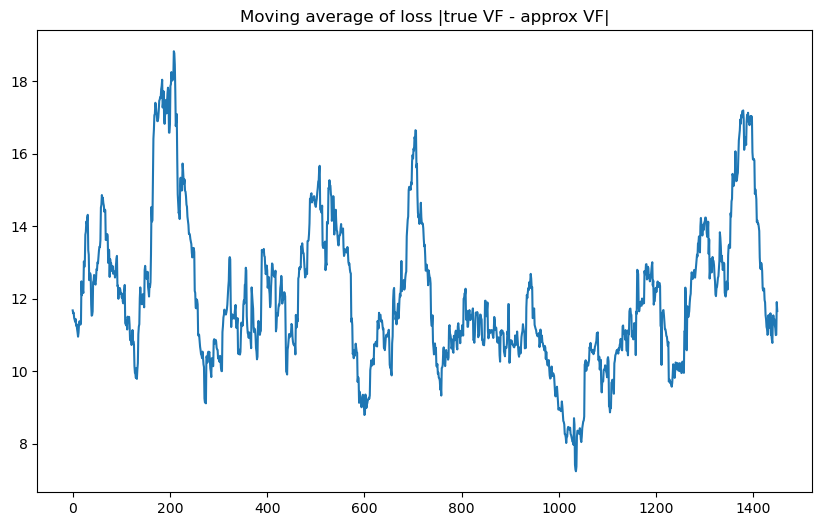

In [13]:
# Compute the moving average with window length 50
window_length = 50
moving_average = sliding_window(np.abs(diff), window_length)

print(np.shape(moving_average))

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(moving_average, label = "Moving Average")

ax.set_title("Moving average of loss |true VF - approx VF|")

In [47]:
def choose_move_test(moves, rack, bag):
    highest_score = 0
    for i in range(len(moves)):
        rack = remove_specific_letters(rack, moves[i].word)
        features = vectorize(moves[i].word, bag)
        features = np.array(features)
        with tf.GradientTape() as tape:
            # Forward pass: compute predicted y using the model
            prediction = model(features.reshape(1, FV_WEIGHT_NUM))
        # Check to see what move is the highest score + predicted penalty with 
        if moves[i].score + prediction > highest_score:
            highest_move = moves[i]
            highest_score = moves[i].score + prediction
        # Now, put the letters back into the rack:
        for l in range(len(moves[i].word)):
            rack.append(moves[i].word[l])
    
    # print(highest_move.word)
    return highest_move




In [48]:
win_count = 0
for i in range(100):
    print("Game:",i)
    bag = bag_o.copy()
    random.shuffle(bag)
    score1 = 0  # resetting the scores and bag:
    score2 = 0
    game = sc.Game(filename="/Users/sbrosh1/Documents/GitHub/scrabbler/games/start_state.p",
                            global_dictionary=global_dictionary, enable_logger=False)
    rack1 = []
    rack2 = []
    for i in range(RACK_MAX):
        rack1.append(bag.pop())
        rack2.append(bag.pop())

    while len(bag) > 0:

        moves = game.find_best_moves(rack1, num = 10)
        if moves:
            move = choose_move_test(moves, rack1, bag)
            game.play(move.start_square, move.word, move.direction)
            score1 = score1 + move.score

            rack1 = remove_specific_letters(rack1, move.word)
                
            # Draw the number of letters played:
            for l in range(len(move.word)):
                if len(bag) > 0:
                    rack1.append(bag.pop())


            
        moves = game.find_best_moves(rack2, num = 1)
        if moves:
            game.play(moves[0].start_square, moves[0].word, moves[0].direction)
            score2 = score2 + moves[0].score

            rack2 = remove_specific_letters(rack2, moves[0].word)
            for l in range(len(moves[0].word)):
                if len(bag) > 0:
                    rack2.append(bag.pop())

    if score1 > score2:
        win_count += 1




Game: 0
Game: 1
Game: 2
Game: 3
Game: 4
Game: 5
Game: 6
Game: 7
Game: 8
Game: 9
Game: 10
Game: 11
Game: 12
Game: 13
Game: 14
Game: 15
Game: 16
Game: 17
Game: 18
Game: 19
Game: 20
Game: 21
Game: 22
Game: 23
Game: 24
Game: 25
Game: 26
Game: 27
Game: 28
Game: 29
Game: 30
Game: 31
Game: 32
Game: 33
Game: 34
Game: 35
Game: 36
Game: 37
Game: 38
Game: 39
Game: 40
Game: 41
Game: 42
Game: 43
Game: 44
Game: 45
Game: 46
Game: 47
Game: 48
Game: 49
Game: 50
Game: 51
Game: 52
Game: 53
Game: 54
Game: 55
Game: 56
Game: 57
Game: 58
Game: 59
Game: 60
Game: 61
Game: 62
Game: 63
Game: 64
Game: 65
Game: 66
Game: 67
Game: 68
Game: 69
Game: 70
Game: 71
Game: 72
Game: 73
Game: 74
Game: 75
Game: 76
Game: 77
Game: 78
Game: 79
Game: 80
Game: 81
Game: 82
Game: 83
Game: 84
Game: 85
Game: 86
Game: 87
Game: 88
Game: 89
Game: 90
Game: 91
Game: 92
Game: 93
Game: 94
Game: 95
Game: 96
Game: 97
Game: 98
Game: 99


In [49]:
print("Win %:", win_count / 100)

Win %: 0.37
